# CME Dataset Preprocessing

## Stratified Sampling Strategy

This notebook preprocesses the CME dataset (CSV) using stratified sampling to create:

1. **Training Set**: 2/3 of the total rows
2. **Test Set**: 1/3 of the total rows
3. **Cross-Validation Folds**: 4 folds where each fold represents 1/4 of the training set
   - **Subtraining Set**: 3/4 of the folds (75% of training data)
   - **Validation Set**: The left-out 1/4 fold (25% of training data)


In [1]:
SEP_CME_PATH = 'C:/Users/the_3/Documents/github/keras-functional-api/data/sep_cme/SEP10MeV.csv'

In [17]:
import pandas as pd
from typing import List, Union, Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
def analyze_dataframe(df: pd.DataFrame) -> None:
    """
    Analyze a dataframe by printing its dimensions, column names, and statistics for each column.
    
    Parameters:
    - df (pd.DataFrame): The dataframe to analyze
    
    Returns:
    - None: This function only prints information, it doesn't return any values
    """
    # --- Get dataset dimensions ---
    num_rows, num_cols = df.shape
    print(f"Number of rows: {num_rows}")
    print(f"Number of columns: {num_cols}")

    # --- Get column names with statistics ---
    print("\n--- Column Names and Statistics ---")
    for col in sorted(df.columns):
        stats = []
        try:
            # Attempt to get min/max - might fail for non-numeric/non-comparable types
            min_val = df[col].min()
            max_val = df[col].max()
            stats.append(f"Min: {min_val}")
            stats.append(f"Max: {max_val}")
        except TypeError:
            stats.append("Min/Max: NA")

        # Get unique count - works for most types
        unique_count = df[col].nunique()
        stats.append(f"Unique: {unique_count}")
        
        # Display column name with its statistics on the same line
        print(f"- {col:<25} | {' | '.join(stats)}")


# Load and analyze the dataset
try:
    # Load the dataset from the specified path
    df = pd.read_csv(SEP_CME_PATH)
    
    # Analyze the loaded dataframe
    analyze_dataframe(df)
    
except FileNotFoundError:
    print(f"Error: File not found at '{SEP_CME_PATH}'. Please provide the correct file path.")
except Exception as e:
    print(f"An error occurred: {e}")

Number of rows: 2297
Number of columns: 29

--- Column Names and Statistics ---
- 2nd_order_speed_20R       | Min: 0 | Max: 3728 | Unique: 878
- 2nd_order_speed_final     | Min: 0 | Max: 3090 | Unique: 883
- Accelaration              | Min: -240.1 | Max: 711.6 | Unique: 681
- CME_CDAW_LinearSpeed      | Min: 26 | Max: 3163 | Unique: 876
- CME_CDAW_MPA              | Min: 0 | Max: 360 | Unique: 355
- CME_CDAW_time             | Min: 1/1/2012 13:36 | Max: 9/9/2017 23:12 | Unique: 2293
- CME_DONKI_latitude        | Min: -88 | Max: 90 | Unique: 161
- CME_DONKI_longitude       | Min: -180.0 | Max: 180.0 | Unique: 355
- CME_DONKI_speed           | Min: 60 | Max: 2800 | Unique: 713
- CME_DONKI_time            | Min: 1/1/2012 13:36 | Max: 9/9/2017 23:12 | Unique: 2297
- CMEs_in_past_9hours       | Min: 1 | Max: 5 | Unique: 5
- CMEs_in_past_month        | Min: 1 | Max: 78 | Unique: 78
- CMEs_with_speed_over_1000_in_past_9hours | Min: 0 | Max: 2 | Unique: 3
- CPA                       | Min: 0 |

In [4]:
def min_max_norm(data: Union[pd.DataFrame, pd.Series]) -> Union[pd.DataFrame, pd.Series]:
    """
    Apply min-max normalization to a pandas DataFrame or Series.
    If the min and max values of a column are the same, that column is replaced with zeros.

    Parameters:
    - cme_files (pd.DataFrame or pd.Series): The pandas DataFrame or Series to be normalized.

    Returns:
    - pd.DataFrame or pd.Series: Min-max normalized pandas DataFrame or Series.
    """

    # Function to normalize a single column
    def normalize_column(column: pd.Series) -> pd.Series:
        min_val = column.min()
        max_val = column.max()

        # Handle case where max and min are the same
        if min_val == max_val:
            return pd.Series(np.zeros_like(column), index=column.index)
        else:
            # Apply min-max normalization
            return (column - min_val) / (max_val - min_val)

    # Check if the input is a DataFrame
    if isinstance(data, pd.DataFrame):
        normalized_df = data.apply(normalize_column, axis=0)
        return normalized_df

    # Check if the input is a Series
    elif isinstance(data, pd.Series):
        return normalize_column(data)

    else:
        raise TypeError("Input must be a pandas DataFrame or Series")

In [5]:
def preprocess_cme_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply preprocessing steps to the CME dataset features.
    
    Parameters:
    - df (pd.DataFrame): The dataframe to preprocess.
    
    Returns:
    - pd.DataFrame: The preprocessed dataframe.
    """
    # Preallocate a dictionary to store preprocessed data
    preprocessed_data = {}
    
    # Include ln_peak_intensity without normalization (as it will be the target)
    preprocessed_data['ln_peak_intensity'] = df['ln_peak_intensity']
    
    # Process solar_wind_speed (was missing)
    preprocessed_data['solar_wind_speed_norm'] = min_max_norm(df['solar_wind_speed'])
    
    # Process connection_angle_degrees (was missing)
    preprocessed_data['connection_angle_degrees_norm'] = min_max_norm(df['connection_angle_degrees'])
    
    # Log transformations for specific features
    preprocessed_data['log_half_richardson_value'] = np.log1p(-df['half_richardson_value'])
    preprocessed_data['log_diffusive_shock'] = np.log1p(df['diffusive_shock'])
    preprocessed_data['log_Type2_Viz_Area'] = df['Type2_Viz_Area'].apply(lambda x: np.log(x) if x != 0 else np.log(1))
    
    # Apply Min-Max normalization on all features, including the log-transformed ones
    for feature, proper_name in {'VlogV': 'VlogV', 
                                'CME_DONKI_speed': 'CME_DONKI_speed',
                                'CME_DONKI_latitude': 'CME_DONKI_latitude', 
                                'CME_DONKI_longitude': 'CME_DONKI_longitude', 
                                'CME_CDAW_MPA': 'CME_CDAW_MPA',
                                'CME_CDAW_LinearSpeed': 'CME_CDAW_LinearSpeed',
                                'DONKI_half_width': 'DONKI_half_width',
                                'Accelaration': 'Accelaration',
                                '2nd_order_speed_final': '2nd_order_speed_final',
                                '2nd_order_speed_20R': '2nd_order_speed_20R',
                                'CPA': 'CPA',
                                'daily_sunspots': 'daily_sunspots',
                                'CMEs_in_past_month': 'CMEs_in_past_month',
                                'CMEs_in_past_9hours': 'CMEs_in_past_9hours',
                                'CMEs_with_speed_over_1000_in_past_9hours': 'CMEs_with_speed_over_1000_in_past_9hours',
                                'max_CME_speed_in_past_day': 'max_CME_speed_in_past_day'}.items():
        preprocessed_data[f"{feature}_norm"] = min_max_norm(df[proper_name])
    
    # Normalize the log-transformed features
    preprocessed_data['log_richardson_value_norm'] = min_max_norm(preprocessed_data['log_half_richardson_value'])
    preprocessed_data['log_diffusive_shock_norm'] = min_max_norm(preprocessed_data['log_diffusive_shock'])
    preprocessed_data['log_Type2_Viz_Area_norm'] = min_max_norm(preprocessed_data['log_Type2_Viz_Area'])
    
    # No transformation for 'Halo'
    preprocessed_data['Halo'] = df['Halo']
    
    # Remove intermediate log-transformed columns
    preprocessed_data.pop('log_half_richardson_value')
    preprocessed_data.pop('log_diffusive_shock')
    preprocessed_data.pop('log_Type2_Viz_Area')
    
    return pd.DataFrame(preprocessed_data)

In [6]:
# preprocess the dataset
preprocessed_df = preprocess_cme_features(df)

# print the statistics of the preprocessed dataframe
analyze_dataframe(preprocessed_df)




Number of rows: 2297
Number of columns: 23

--- Column Names and Statistics ---
- 2nd_order_speed_20R_norm  | Min: 0.0 | Max: 1.0 | Unique: 878
- 2nd_order_speed_final_norm | Min: 0.0 | Max: 1.0 | Unique: 883
- Accelaration_norm         | Min: 0.0 | Max: 1.0 | Unique: 681
- CME_CDAW_LinearSpeed_norm | Min: 0.0 | Max: 1.0 | Unique: 876
- CME_CDAW_MPA_norm         | Min: 0.0 | Max: 1.0 | Unique: 355
- CME_DONKI_latitude_norm   | Min: 0.0 | Max: 1.0 | Unique: 161
- CME_DONKI_longitude_norm  | Min: 0.0 | Max: 1.0 | Unique: 355
- CME_DONKI_speed_norm      | Min: 0.0 | Max: 1.0 | Unique: 713
- CMEs_in_past_9hours_norm  | Min: 0.0 | Max: 1.0 | Unique: 5
- CMEs_in_past_month_norm   | Min: 0.0 | Max: 1.0 | Unique: 78
- CMEs_with_speed_over_1000_in_past_9hours_norm | Min: 0.0 | Max: 1.0 | Unique: 3
- CPA_norm                  | Min: 0.0 | Max: 1.0 | Unique: 350
- DONKI_half_width_norm     | Min: 0.0 | Max: 1.0 | Unique: 71
- Halo                      | Min: 0 | Max: 1 | Unique: 2
- VlogV_norm   

In [24]:
def save_and_verify_dataset(
    df: pd.DataFrame, 
    output_path: str, 
    dataset_name: str = "Dataset", 
    target_column: str = "ln_peak_intensity",
    verify: bool = True
) -> pd.DataFrame:
    """
    Save a dataframe to CSV and optionally verify it was saved correctly.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe to save
    output_path : str
        Path where the CSV file should be saved
    dataset_name : str, optional
        Name of the dataset for display in verification messages
    target_column : str, optional
        Name of the target column to verify its position
    verify : bool, optional
        Whether to load and verify the saved file
        
    Returns:
    --------
    pd.DataFrame
        The loaded dataframe if verify=True, otherwise None
    """
    # Save the dataframe to CSV
    df.to_csv(output_path, index=False)
    print(f"{dataset_name} saved to: {output_path}")
    
    if not verify:
        return None
    
    # Load the saved CSV file to verify it was saved correctly
    loaded_df = pd.read_csv(output_path)
    print(f"\nLoaded {dataset_name.lower()} from: {output_path}")
    print(f"Shape of loaded {dataset_name.lower()}: {loaded_df.shape}")
    
    # Analyze the loaded dataframe to verify preprocessing was successful
    print(f"\nAnalysis of the loaded {dataset_name.lower()}:")
    analyze_dataframe(loaded_df)
    
    # Verify that the target column is the last column
    print(f"\nVerifying target column position for {dataset_name.lower()}:")
    print(f"Last column in loaded {dataset_name.lower()}: {loaded_df.columns[-1]}")
    
    if loaded_df.columns[-1] == target_column:
        print(f"✓ Target column '{target_column}' is correctly positioned as the last column")
    else:
        print(f"✗ Target column '{target_column}' is not in the expected position")
    
    return loaded_df

In [7]:
# Rearrange columns to place ln_peak_intensity last
cols = [col for col in preprocessed_df.columns if col != 'ln_peak_intensity']
cols.append('ln_peak_intensity')
preprocessed_df = preprocessed_df[cols]

# Define the output path in the same directory as the original file
output_dir = os.path.dirname(SEP_CME_PATH)
output_path = os.path.join(output_dir, 'SEP10MeV_preprocessed.csv')

# Print column order before saving
print("\nColumns in the file (last one is the target):")
print(', '.join(cols))

# Save and verify the dataset using the function
loaded_df = save_and_verify_dataset(
    df=preprocessed_df,
    output_path=output_path,
    dataset_name="Preprocessed data",
    target_column="ln_peak_intensity",
    verify=True
)

Preprocessed data saved to: C:/Users/the_3/Documents/github/keras-functional-api/data/sep_cme\SEP10MeV_preprocessed.csv

Columns in the saved file (last one is the target):
solar_wind_speed_norm, connection_angle_degrees_norm, VlogV_norm, CME_DONKI_speed_norm, CME_DONKI_latitude_norm, CME_DONKI_longitude_norm, CME_CDAW_MPA_norm, CME_CDAW_LinearSpeed_norm, DONKI_half_width_norm, Accelaration_norm, 2nd_order_speed_final_norm, 2nd_order_speed_20R_norm, CPA_norm, daily_sunspots_norm, CMEs_in_past_month_norm, CMEs_in_past_9hours_norm, CMEs_with_speed_over_1000_in_past_9hours_norm, max_CME_speed_in_past_day_norm, log_richardson_value_norm, log_diffusive_shock_norm, log_Type2_Viz_Area_norm, Halo, ln_peak_intensity


In [12]:
def stratified_split(
        df: pd.DataFrame,
        label_column: str = 'ln_peak_intensity',
        seed: int = None
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits the dataframe into training and testing sets using stratified sampling based on the label column.
    Training set will contain 2/3 of the data, and testing set will contain 1/3.
    
    Parameters:
    df (pd.DataFrame): The dataframe to split.
    label_column (str): The name of the column to use as the label for stratification.
    seed (int): Random seed for reproducibility. Default is None.
    
    Returns:
    Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing:
        - df_train: DataFrame for the training set (2/3 of data)
        - df_test: DataFrame for the testing set (1/3 of data)
    """
    if seed is not None:
        np.random.seed(seed)
        print(f"Random seed set to: {seed}")
    
    # Extract labels
    y = df[label_column].values.reshape(-1, 1)
    
    # Sort the data by the labels
    sorted_indices = np.argsort(y, axis=0).flatten()
    df_sorted = df.iloc[sorted_indices].reset_index(drop=True)
    print(f"Data sorted by {label_column} values")
    
    # Calculate the number of samples
    num_samples = len(df)
    
    # Lists to hold training and testing indices
    train_indices, test_indices = [], []
    
    # Divide into groups of 3 and split: 2 for training, 1 for testing
    for i in range(0, num_samples, 3):
        group_indices = list(range(i, min(i + 3, num_samples)))
        print(f"Group {i//3} size: {len(group_indices)}", end=',')
        
        # Take 1/3 for testing, 2/3 for training
        split_point = max(1, len(group_indices) // 3)
        test_group = group_indices[:split_point]
        train_group = group_indices[split_point:]
        
        test_indices.extend(test_group)
        train_indices.extend(train_group)
    
    # Create the dataframes
    df_train = df_sorted.iloc[train_indices].reset_index(drop=True)
    df_test = df_sorted.iloc[test_indices].reset_index(drop=True)
    
    # Print splitting statistics
    print(f"Total samples: {num_samples}")
    print(f"Train samples: {len(df_train)} ({len(df_train)/num_samples:.2%})")
    print(f"Test samples: {len(df_test)} ({len(df_test)/num_samples:.2%})")
    print(f"Train {label_column} range: {df_train[label_column].min():.4f} to {df_train[label_column].max():.4f}")
    print(f"Test {label_column} range: {df_test[label_column].min():.4f} to {df_test[label_column].max():.4f}")
    
    return df_train, df_test

In [13]:
# split the dataset into training and testing sets
df_train, df_test = stratified_split(preprocessed_df)

# print the statistics of the training and testing sets
analyze_dataframe(df_train)
analyze_dataframe(df_test)



Data sorted by ln_peak_intensity values
Group 0 size: 3,Group 1 size: 3,Group 2 size: 3,Group 3 size: 3,Group 4 size: 3,Group 5 size: 3,Group 6 size: 3,Group 7 size: 3,Group 8 size: 3,Group 9 size: 3,Group 10 size: 3,Group 11 size: 3,Group 12 size: 3,Group 13 size: 3,Group 14 size: 3,Group 15 size: 3,Group 16 size: 3,Group 17 size: 3,Group 18 size: 3,Group 19 size: 3,Group 20 size: 3,Group 21 size: 3,Group 22 size: 3,Group 23 size: 3,Group 24 size: 3,Group 25 size: 3,Group 26 size: 3,Group 27 size: 3,Group 28 size: 3,Group 29 size: 3,Group 30 size: 3,Group 31 size: 3,Group 32 size: 3,Group 33 size: 3,Group 34 size: 3,Group 35 size: 3,Group 36 size: 3,Group 37 size: 3,Group 38 size: 3,Group 39 size: 3,Group 40 size: 3,Group 41 size: 3,Group 42 size: 3,Group 43 size: 3,Group 44 size: 3,Group 45 size: 3,Group 46 size: 3,Group 47 size: 3,Group 48 size: 3,Group 49 size: 3,Group 50 size: 3,Group 51 size: 3,Group 52 size: 3,Group 53 size: 3,Group 54 size: 3,Group 55 size: 3,Group 56 size: 3,G

In [20]:
def plot_dfs_distr(*dataframes: List[pd.DataFrame], 
                   target_column: str = 'ln_peak_intensity',
                   labels: Optional[List[str]] = None, 
                   figsize: Tuple[int, int] = (12, 6), 
                   bins: int = 10) -> None:
    """
    Plot the distribution of a target column for multiple dataframes for comparison.
    
    Parameters:
    -----------
    *dataframes : List[pd.DataFrame]
        Variable number of pandas DataFrames to compare
    target_column : str, default='ln_peak_intensity'
        The column name to plot distributions for
    labels : Optional[List[str]], default=None
        List of labels for each dataframe (for the legend)
    figsize : Tuple[int, int], default=(12, 6)
        Tuple specifying figure size (width, height)
    bins : int, default=10
        Number of bins for the histogram
        
    Returns:
    --------
    None
        Displays the plot but doesn't return any value
    """
    # Generate default labels if none provided
    if labels is None:
        labels = [f"DataFrame {i+1}" for i in range(len(dataframes))]
    
    # Create figure with two subplots - KDE and histogram
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Set a different color for each dataframe
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # Plot KDE (Kernel Density Estimation) for each dataframe on the first subplot
    for i, df in enumerate(dataframes):
        sns.kdeplot(
            df[target_column], 
            ax=ax1, 
            label=labels[i], 
            color=colors[i % len(colors)],
            fill=False,  # Don't fill colors on the KDE
            alpha=1.0    # Full opacity for clear lines
        )
    
    # Set titles and labels for KDE plot
    ax1.set_title(f'Density Distribution of {target_column}')
    ax1.set_xlabel(target_column)
    ax1.set_ylabel('Density')
    ax1.legend()
    
    # Plot histograms on the second subplot with non-overlapping bars
    bin_edges = np.linspace(
        min(df[target_column].min() for df in dataframes),
        max(df[target_column].max() for df in dataframes),
        bins + 1
    )
    
    bar_width = (bin_edges[1] - bin_edges[0]) / (len(dataframes) + 0.2)
    
    for i, df in enumerate(dataframes):
        # Calculate histogram values
        hist, _ = np.histogram(df[target_column], bins=bin_edges, density=True)
        # Calculate the center position for each bar group
        bar_positions = bin_edges[:-1] + i * bar_width
        
        ax2.bar(
            bar_positions, 
            hist,
            width=bar_width * 0.9,  # Slightly narrower to create separation
            alpha=0.8, 
            label=labels[i],
            color=colors[i % len(colors)]
        )
    
    # Set titles and labels for histogram
    ax2.set_title(f'Histogram of {target_column}')
    ax2.set_xlabel(target_column)
    ax2.set_ylabel('Normalized Frequency')
    ax2.legend()
    
    # Add descriptive statistics below the plots
    for i, df in enumerate(dataframes):
        stats = (
            f"{labels[i]}: "
            f"Mean={df[target_column].mean():.2f}, "
            f"Median={df[target_column].median():.2f}, "
            f"Min={df[target_column].min():.2f}, "
            f"Max={df[target_column].max():.2f}"
        )
        plt.figtext(0.5, 0.01 - i*0.03, stats, ha='center', fontsize=9)
    
    # Adjust layout to make room for statistics text
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()


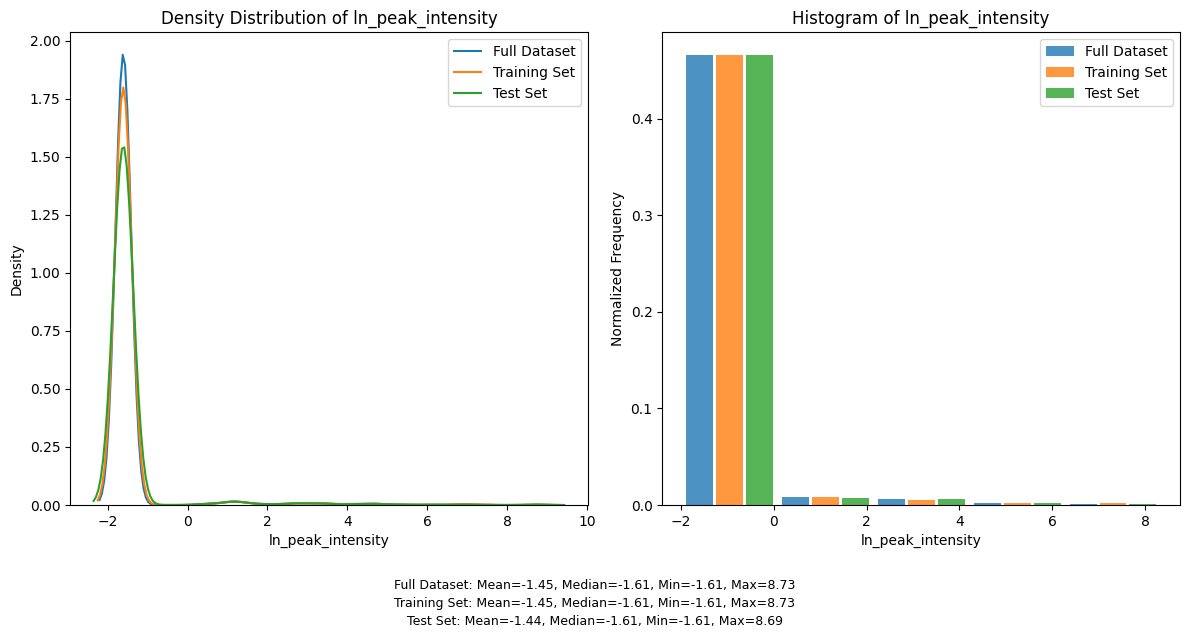

In [22]:
plot_dfs_distr(
    preprocessed_df, df_train, df_test, 
    target_column='ln_peak_intensity',
    labels=['Full Dataset', 'Training Set', 'Test Set'],
    bins=5
)

In [23]:
# Define output directory and file paths
output_dir = os.path.dirname(SEP_CME_PATH)
train_output_path = os.path.join(output_dir, 'sep_10mev_training.csv')
test_output_path = os.path.join(output_dir, 'sep_10mev_testing.csv')

# Save and verify training dataset
loaded_train_df = save_and_verify_dataset(
    df_train, 
    train_output_path, 
    dataset_name="Training data",
    target_column="ln_peak_intensity"
)

# Save and verify testing dataset
loaded_test_df = save_and_verify_dataset(
    df_test, 
    test_output_path, 
    dataset_name="Testing data",
    target_column="ln_peak_intensity"
)

# Verify both datasets together
print("\nVerifying target column position across both datasets:")
if (loaded_train_df.columns[-1] == "ln_peak_intensity" and 
    loaded_test_df.columns[-1] == "ln_peak_intensity"):
    print("✓ Target column 'ln_peak_intensity' is correctly positioned as the last column in both datasets")
else:
    print("✗ Target column is not in the expected position in one or both datasets")


Training data saved to: C:/Users/the_3/Documents/github/keras-functional-api/data/sep_cme\sep_10mev_training.csv
Testing data saved to: C:/Users/the_3/Documents/github/keras-functional-api/data/sep_cme\sep_10mev_testing.csv

Loaded training data from: C:/Users/the_3/Documents/github/keras-functional-api/data/sep_cme\sep_10mev_training.csv
Shape of loaded training data: (1531, 23)

Loaded testing data from: C:/Users/the_3/Documents/github/keras-functional-api/data/sep_cme\sep_10mev_testing.csv
Shape of loaded testing data: (766, 23)

Analysis of the loaded training data:
Number of rows: 1531
Number of columns: 23

--- Column Names and Statistics ---
- 2nd_order_speed_20R_norm  | Min: 0.0 | Max: 1.0 | Unique: 729
- 2nd_order_speed_final_norm | Min: 0.0 | Max: 1.0 | Unique: 740
- Accelaration_norm         | Min: 0.0 | Max: 1.0 | Unique: 568
- CME_CDAW_LinearSpeed_norm | Min: 0.0089257252151737 | Max: 1.0 | Unique: 734
- CME_CDAW_MPA_norm         | Min: 0.0 | Max: 1.0 | Unique: 346
- CME_D